In this sheet I will apply Convolutional Neural Networks for stock prediction of S&P500 index. I will divide data from last 20 years into chunks. Every day contains four values: opening, low, high and closing ones - therefore input data for 30-day chunk has size 30x4. Predicted output has three classes: whether stock will go up, down or stay constant X days after last input.

Story: Investor observes stock for 60 days. Then decides whether buy some stocks and sell it after 10 days. Therefore input consist of stock prices from day 1st to 60th, output is:
* 0 if price will go down by more than \$\{PERCENTAGE_THRESHOLD\}%, 
* 1 if price will not go up or down by more than \$\{PERCENTAGE_THRESHOLD\}% 
* 2 if price will go up by more than \$\{PERCENTAGE_THRESHOLD\}%

Relative change output is calculated using the following formula: (opening_price_on_buyout_day -closing_price_on_last_day_of_observation) / opening_price_on_buyout_day * 100%

Based on percentage value from formula above, label will be calculated.

In [67]:
OBSERVATION_TIME = 60
PREDICTION_AFTER_DAYS = 10
PERCENTAGE_THRESHOLD = 1
EPOCHS = 500
TEST_SIZE = 0.10
RANDOM_SPLIT = False

In [51]:
import pandas as pd

df = pd.read_csv('./data/sp500_20Y_without_covid.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000


In [52]:
def percentage_to_label(percentage_value):
    return 0 if percentage_value < -PERCENTAGE_THRESHOLD else 1 if percentage_value <= PERCENTAGE_THRESHOLD else 2

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=OBSERVATION_TIME, then_buy_stocks=True, and_sells_them=True, after_y_days=PREDICTION_AFTER_DAYS)

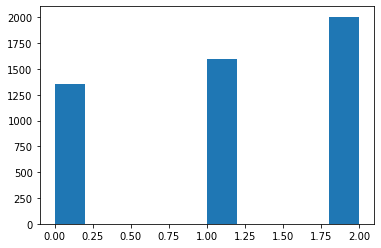

2    2005
1    1598
0    1357
dtype: int64

In [55]:
import matplotlib.pyplot as plt

plt.hist(observation_results)
plt.show()

pd.Series(observation_results).value_counts()

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

In [56]:
import numpy as np
from keras.utils import to_categorical

def categorical_labels(label_array):
    return to_categorical(label_array)

categorical_labels(observation_results)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [57]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (60, 5), filters=16, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 60, 16)            336       
_________________________________________________________________
batch_normalization_7 (Batch (None, 60, 16)            64        
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 60, 16)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 16)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 60, 8)             520       
_________________________________________________________________
batch_normalization_8 (Batch (None, 60, 8)             32        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 60, 8)            

In [68]:
from keras.optimizers import Nadam
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


model.compile(optimizer=Nadam(lr=0.002),
              loss='categorical_crossentropy',
              metrics=METRICS)

In [69]:
from sklearn.model_selection import train_test_split

X = np.array(list(map(lambda df: df[['Open', 'High', 'Low', 'Close', 'Adj Close']].to_numpy(), observed_chunks)))
Y = np.array(categorical_labels(observation_results))

def chronological_split(X_data, Y_data, test_size=0.25):
    training_test_split_index = int((1 - test_size) * len(X_data))
    X_train = X_data[:training_test_split_index]
    Y_train = Y_data[:training_test_split_index]
    X_test = X_data[training_test_split_index:]
    Y_test = Y_data[training_test_split_index:]
    return X_train, X_test, Y_train, Y_test
    
def random_split(X_data, Y_data, test_size=0.25):
    return train_test_split(X_data, Y_data, test_size=test_size, random_state=42)

X_train, X_test, Y_train, Y_test = random_split(X, Y, TEST_SIZE) if RANDOM_SPLIT else chronological_split(X, Y, TEST_SIZE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((4464, 60, 5), (4464, 3), (496, 60, 5), (496, 3))

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath="model.hdf5", verbose=1, save_best_only=True)

history = model.fit(x=X_train, 
                    y=Y_train, 
                    batch_size=128, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, Y_test),
                    shuffle=True,
                    callbacks = [checkpointer])

Train on 4464 samples, validate on 496 samples
Epoch 1/500
4464/4464 [==============================] - 1s 261us/step - loss: 0.9900 - tp: 1438.0000 - fp: 997.0000 - tn: 7931.0000 - fn: 3026.0000 - accuracy: 0.5262 - precision: 0.5906 - recall: 0.3221 - auc: 0.7071 - val_loss: 1.7286 - val_tp: 141.0000 - val_fp: 258.0000 - val_tn: 734.0000 - val_fn: 355.0000 - val_accuracy: 0.3367 - val_precision: 0.3534 - val_recall: 0.2843 - val_auc: 0.4827

Epoch 00001: val_loss improved from inf to 1.72863, saving model to model.hdf5
Epoch 2/500
4464/4464 [==============================] - 0s 77us/step - loss: 0.9833 - tp: 1452.0000 - fp: 954.0000 - tn: 7974.0000 - fn: 3012.0000 - accuracy: 0.5224 - precision: 0.6035 - recall: 0.3253 - auc: 0.7098 - val_loss: 1.3920 - val_tp: 130.0000 - val_fp: 213.0000 - val_tn: 779.0000 - val_fn: 366.0000 - val_accuracy: 0.3589 - val_precision: 0.3790 - val_recall: 0.2621 - val_auc: 0.5581

Epoch 00002: val_loss improved from 1.72863 to 1.39199, saving model to m


Epoch 00018: val_loss did not improve from 1.26231
Epoch 19/500
4464/4464 [==============================] - 0s 70us/step - loss: 0.9524 - tp: 1461.0000 - fp: 836.0000 - tn: 8092.0000 - fn: 3003.0000 - accuracy: 0.5470 - precision: 0.6360 - recall: 0.3273 - auc: 0.7306 - val_loss: 2.1223 - val_tp: 167.0000 - val_fp: 320.0000 - val_tn: 672.0000 - val_fn: 329.0000 - val_accuracy: 0.3407 - val_precision: 0.3429 - val_recall: 0.3367 - val_auc: 0.5530

Epoch 00019: val_loss did not improve from 1.26231
Epoch 20/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.9648 - tp: 1386.0000 - fp: 842.0000 - tn: 8086.0000 - fn: 3078.0000 - accuracy: 0.5374 - precision: 0.6221 - recall: 0.3105 - auc: 0.7217 - val_loss: 2.2826 - val_tp: 205.0000 - val_fp: 289.0000 - val_tn: 703.0000 - val_fn: 291.0000 - val_accuracy: 0.4153 - val_precision: 0.4150 - val_recall: 0.4133 - val_auc: 0.6067

Epoch 00020: val_loss did not improve from 1.26231
Epoch 21/500
4464/4464 [====================

Epoch 37/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.9504 - tp: 1463.0000 - fp: 813.0000 - tn: 8115.0000 - fn: 3001.0000 - accuracy: 0.5497 - precision: 0.6428 - recall: 0.3277 - auc: 0.7299 - val_loss: 1.2523 - val_tp: 137.0000 - val_fp: 162.0000 - val_tn: 830.0000 - val_fn: 359.0000 - val_accuracy: 0.3992 - val_precision: 0.4582 - val_recall: 0.2762 - val_auc: 0.5723

Epoch 00037: val_loss did not improve from 1.20694
Epoch 38/500
4464/4464 [==============================] - 0s 69us/step - loss: 0.9561 - tp: 1468.0000 - fp: 839.0000 - tn: 8089.0000 - fn: 2996.0000 - accuracy: 0.5497 - precision: 0.6363 - recall: 0.3289 - auc: 0.7298 - val_loss: 1.3967 - val_tp: 139.0000 - val_fp: 194.0000 - val_tn: 798.0000 - val_fn: 357.0000 - val_accuracy: 0.3931 - val_precision: 0.4174 - val_recall: 0.2802 - val_auc: 0.5611

Epoch 00038: val_loss did not improve from 1.20694
Epoch 39/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.9641 - tp: 1319

4464/4464 [==============================] - 0s 70us/step - loss: 0.9392 - tp: 1502.0000 - fp: 858.0000 - tn: 8070.0000 - fn: 2962.0000 - accuracy: 0.5553 - precision: 0.6364 - recall: 0.3365 - auc: 0.7380 - val_loss: 1.3833 - val_tp: 171.0000 - val_fp: 236.0000 - val_tn: 756.0000 - val_fn: 325.0000 - val_accuracy: 0.3992 - val_precision: 0.4201 - val_recall: 0.3448 - val_auc: 0.5696

Epoch 00055: val_loss did not improve from 1.20694
Epoch 56/500
4464/4464 [==============================] - 0s 69us/step - loss: 0.9374 - tp: 1538.0000 - fp: 815.0000 - tn: 8113.0000 - fn: 2926.0000 - accuracy: 0.5526 - precision: 0.6536 - recall: 0.3445 - auc: 0.7412 - val_loss: 1.2069 - val_tp: 125.0000 - val_fp: 144.0000 - val_tn: 848.0000 - val_fn: 371.0000 - val_accuracy: 0.4133 - val_precision: 0.4647 - val_recall: 0.2520 - val_auc: 0.5891

Epoch 00056: val_loss improved from 1.20694 to 1.20685, saving model to model.hdf5
Epoch 57/500
4464/4464 [==============================] - 0s 71us/step - loss

4464/4464 [==============================] - 0s 70us/step - loss: 0.9452 - tp: 1506.0000 - fp: 845.0000 - tn: 8083.0000 - fn: 2958.0000 - accuracy: 0.5437 - precision: 0.6406 - recall: 0.3374 - auc: 0.7340 - val_loss: 1.9692 - val_tp: 160.0000 - val_fp: 322.0000 - val_tn: 670.0000 - val_fn: 336.0000 - val_accuracy: 0.3306 - val_precision: 0.3320 - val_recall: 0.3226 - val_auc: 0.5319

Epoch 00073: val_loss did not improve from 1.20685
Epoch 74/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.9349 - tp: 1538.0000 - fp: 766.0000 - tn: 8162.0000 - fn: 2926.0000 - accuracy: 0.5616 - precision: 0.6675 - recall: 0.3445 - auc: 0.7441 - val_loss: 1.3243 - val_tp: 110.0000 - val_fp: 159.0000 - val_tn: 833.0000 - val_fn: 386.0000 - val_accuracy: 0.3730 - val_precision: 0.4089 - val_recall: 0.2218 - val_auc: 0.5390

Epoch 00074: val_loss did not improve from 1.20685
Epoch 75/500
4464/4464 [==============================] - 0s 74us/step - loss: 0.9401 - tp: 1561.0000 - fp: 8

4464/4464 [==============================] - 0s 71us/step - loss: 0.9335 - tp: 1576.0000 - fp: 819.0000 - tn: 8109.0000 - fn: 2888.0000 - accuracy: 0.5627 - precision: 0.6580 - recall: 0.3530 - auc: 0.7444 - val_loss: 1.3098 - val_tp: 145.0000 - val_fp: 171.0000 - val_tn: 821.0000 - val_fn: 351.0000 - val_accuracy: 0.4214 - val_precision: 0.4589 - val_recall: 0.2923 - val_auc: 0.5864

Epoch 00091: val_loss did not improve from 1.20685
Epoch 92/500
4464/4464 [==============================] - 0s 69us/step - loss: 0.9262 - tp: 1639.0000 - fp: 879.0000 - tn: 8049.0000 - fn: 2825.0000 - accuracy: 0.5656 - precision: 0.6509 - recall: 0.3672 - auc: 0.7477 - val_loss: 1.2885 - val_tp: 185.0000 - val_fp: 218.0000 - val_tn: 774.0000 - val_fn: 311.0000 - val_accuracy: 0.4435 - val_precision: 0.4591 - val_recall: 0.3730 - val_auc: 0.6081

Epoch 00092: val_loss did not improve from 1.20685
Epoch 93/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.9349 - tp: 1535.0000 - fp: 8

4464/4464 [==============================] - 0s 69us/step - loss: 0.9189 - tp: 1663.0000 - fp: 923.0000 - tn: 8005.0000 - fn: 2801.0000 - accuracy: 0.5694 - precision: 0.6431 - recall: 0.3725 - auc: 0.7522 - val_loss: 1.5869 - val_tp: 173.0000 - val_fp: 284.0000 - val_tn: 708.0000 - val_fn: 323.0000 - val_accuracy: 0.3690 - val_precision: 0.3786 - val_recall: 0.3488 - val_auc: 0.5649

Epoch 00109: val_loss did not improve from 1.20685
Epoch 110/500
4464/4464 [==============================] - 0s 67us/step - loss: 0.9307 - tp: 1626.0000 - fp: 888.0000 - tn: 8040.0000 - fn: 2838.0000 - accuracy: 0.5553 - precision: 0.6468 - recall: 0.3642 - auc: 0.7463 - val_loss: 1.2511 - val_tp: 100.0000 - val_fp: 129.0000 - val_tn: 863.0000 - val_fn: 396.0000 - val_accuracy: 0.3992 - val_precision: 0.4367 - val_recall: 0.2016 - val_auc: 0.5659

Epoch 00110: val_loss did not improve from 1.20685
Epoch 111/500
4464/4464 [==============================] - 0s 66us/step - loss: 0.9342 - tp: 1580.0000 - fp:

4464/4464 [==============================] - 0s 70us/step - loss: 0.9251 - tp: 1643.0000 - fp: 886.0000 - tn: 8042.0000 - fn: 2821.0000 - accuracy: 0.5540 - precision: 0.6497 - recall: 0.3681 - auc: 0.7470 - val_loss: 1.3454 - val_tp: 189.0000 - val_fp: 217.0000 - val_tn: 775.0000 - val_fn: 307.0000 - val_accuracy: 0.4738 - val_precision: 0.4655 - val_recall: 0.3810 - val_auc: 0.6185

Epoch 00127: val_loss did not improve from 1.20685
Epoch 128/500
4464/4464 [==============================] - 0s 70us/step - loss: 0.9211 - tp: 1643.0000 - fp: 890.0000 - tn: 8038.0000 - fn: 2821.0000 - accuracy: 0.5672 - precision: 0.6486 - recall: 0.3681 - auc: 0.7508 - val_loss: 2.2723 - val_tp: 154.0000 - val_fp: 332.0000 - val_tn: 660.0000 - val_fn: 342.0000 - val_accuracy: 0.3165 - val_precision: 0.3169 - val_recall: 0.3105 - val_auc: 0.5314

Epoch 00128: val_loss did not improve from 1.20685
Epoch 129/500
4464/4464 [==============================] - 0s 70us/step - loss: 0.9145 - tp: 1679.0000 - fp:

4464/4464 [==============================] - 0s 73us/step - loss: 0.9281 - tp: 1590.0000 - fp: 945.0000 - tn: 7983.0000 - fn: 2874.0000 - accuracy: 0.5576 - precision: 0.6272 - recall: 0.3562 - auc: 0.7444 - val_loss: 1.7350 - val_tp: 190.0000 - val_fp: 252.0000 - val_tn: 740.0000 - val_fn: 306.0000 - val_accuracy: 0.4214 - val_precision: 0.4299 - val_recall: 0.3831 - val_auc: 0.5923

Epoch 00145: val_loss did not improve from 1.20685
Epoch 146/500
4464/4464 [==============================] - 0s 74us/step - loss: 0.9039 - tp: 1709.0000 - fp: 868.0000 - tn: 8060.0000 - fn: 2755.0000 - accuracy: 0.5681 - precision: 0.6632 - recall: 0.3828 - auc: 0.7615 - val_loss: 1.9434 - val_tp: 174.0000 - val_fp: 297.0000 - val_tn: 695.0000 - val_fn: 322.0000 - val_accuracy: 0.3649 - val_precision: 0.3694 - val_recall: 0.3508 - val_auc: 0.5551

Epoch 00146: val_loss did not improve from 1.20685
Epoch 147/500
4464/4464 [==============================] - 0s 80us/step - loss: 0.9131 - tp: 1736.0000 - fp:

4464/4464 [==============================] - 0s 67us/step - loss: 0.9056 - tp: 1757.0000 - fp: 877.0000 - tn: 8051.0000 - fn: 2707.0000 - accuracy: 0.5759 - precision: 0.6670 - recall: 0.3936 - auc: 0.7607 - val_loss: 1.9092 - val_tp: 164.0000 - val_fp: 316.0000 - val_tn: 676.0000 - val_fn: 332.0000 - val_accuracy: 0.3407 - val_precision: 0.3417 - val_recall: 0.3306 - val_auc: 0.5331

Epoch 00163: val_loss did not improve from 1.20685
Epoch 164/500
4464/4464 [==============================] - 0s 67us/step - loss: 0.9022 - tp: 1737.0000 - fp: 900.0000 - tn: 8028.0000 - fn: 2727.0000 - accuracy: 0.5764 - precision: 0.6587 - recall: 0.3891 - auc: 0.7643 - val_loss: 2.1441 - val_tp: 204.0000 - val_fp: 274.0000 - val_tn: 718.0000 - val_fn: 292.0000 - val_accuracy: 0.4274 - val_precision: 0.4268 - val_recall: 0.4113 - val_auc: 0.5906

Epoch 00164: val_loss did not improve from 1.20685
Epoch 165/500
4464/4464 [==============================] - 0s 66us/step - loss: 0.8994 - tp: 1822.0000 - fp:

4464/4464 [==============================] - 0s 67us/step - loss: 0.9017 - tp: 1830.0000 - fp: 877.0000 - tn: 8051.0000 - fn: 2634.0000 - accuracy: 0.5813 - precision: 0.6760 - recall: 0.4099 - auc: 0.7664 - val_loss: 2.4832 - val_tp: 202.0000 - val_fp: 280.0000 - val_tn: 712.0000 - val_fn: 294.0000 - val_accuracy: 0.4153 - val_precision: 0.4191 - val_recall: 0.4073 - val_auc: 0.5892

Epoch 00181: val_loss did not improve from 1.20685
Epoch 182/500
4464/4464 [==============================] - 0s 66us/step - loss: 0.8895 - tp: 1854.0000 - fp: 884.0000 - tn: 8044.0000 - fn: 2610.0000 - accuracy: 0.5912 - precision: 0.6771 - recall: 0.4153 - auc: 0.7735 - val_loss: 1.5716 - val_tp: 192.0000 - val_fp: 242.0000 - val_tn: 750.0000 - val_fn: 304.0000 - val_accuracy: 0.4294 - val_precision: 0.4424 - val_recall: 0.3871 - val_auc: 0.5830

Epoch 00182: val_loss did not improve from 1.20685
Epoch 183/500
4464/4464 [==============================] - 0s 66us/step - loss: 0.9053 - tp: 1772.0000 - fp:

4464/4464 [==============================] - 0s 69us/step - loss: 0.8917 - tp: 1844.0000 - fp: 926.0000 - tn: 8002.0000 - fn: 2620.0000 - accuracy: 0.5874 - precision: 0.6657 - recall: 0.4131 - auc: 0.7706 - val_loss: 2.7855 - val_tp: 236.0000 - val_fp: 253.0000 - val_tn: 739.0000 - val_fn: 260.0000 - val_accuracy: 0.4778 - val_precision: 0.4826 - val_recall: 0.4758 - val_auc: 0.6199

Epoch 00199: val_loss did not improve from 1.20685
Epoch 200/500
4464/4464 [==============================] - 0s 69us/step - loss: 0.8941 - tp: 1834.0000 - fp: 913.0000 - tn: 8015.0000 - fn: 2630.0000 - accuracy: 0.5918 - precision: 0.6676 - recall: 0.4108 - auc: 0.7693 - val_loss: 2.1062 - val_tp: 173.0000 - val_fp: 309.0000 - val_tn: 683.0000 - val_fn: 323.0000 - val_accuracy: 0.3528 - val_precision: 0.3589 - val_recall: 0.3488 - val_auc: 0.5665

Epoch 00200: val_loss did not improve from 1.20685
Epoch 201/500
4464/4464 [==============================] - 0s 69us/step - loss: 0.8957 - tp: 1865.0000 - fp:

4464/4464 [==============================] - 0s 69us/step - loss: 0.8888 - tp: 1844.0000 - fp: 931.0000 - tn: 7997.0000 - fn: 2620.0000 - accuracy: 0.5889 - precision: 0.6645 - recall: 0.4131 - auc: 0.7728 - val_loss: 1.8593 - val_tp: 217.0000 - val_fp: 251.0000 - val_tn: 741.0000 - val_fn: 279.0000 - val_accuracy: 0.4577 - val_precision: 0.4637 - val_recall: 0.4375 - val_auc: 0.6184

Epoch 00217: val_loss did not improve from 1.20685
Epoch 218/500
4464/4464 [==============================] - 0s 71us/step - loss: 0.8836 - tp: 1907.0000 - fp: 929.0000 - tn: 7999.0000 - fn: 2557.0000 - accuracy: 0.5901 - precision: 0.6724 - recall: 0.4272 - auc: 0.7753 - val_loss: 1.5820 - val_tp: 169.0000 - val_fp: 257.0000 - val_tn: 735.0000 - val_fn: 327.0000 - val_accuracy: 0.4032 - val_precision: 0.3967 - val_recall: 0.3407 - val_auc: 0.5610

Epoch 00218: val_loss did not improve from 1.20685
Epoch 219/500
4464/4464 [==============================] - 0s 71us/step - loss: 0.8952 - tp: 1815.0000 - fp:

4464/4464 [==============================] - 0s 77us/step - loss: 0.8860 - tp: 1878.0000 - fp: 909.0000 - tn: 8019.0000 - fn: 2586.0000 - accuracy: 0.5869 - precision: 0.6738 - recall: 0.4207 - auc: 0.7739 - val_loss: 1.7196 - val_tp: 196.0000 - val_fp: 268.0000 - val_tn: 724.0000 - val_fn: 300.0000 - val_accuracy: 0.4315 - val_precision: 0.4224 - val_recall: 0.3952 - val_auc: 0.5726

Epoch 00235: val_loss did not improve from 1.20685
Epoch 236/500
4464/4464 [==============================] - 0s 75us/step - loss: 0.8852 - tp: 1895.0000 - fp: 931.0000 - tn: 7997.0000 - fn: 2569.0000 - accuracy: 0.5878 - precision: 0.6706 - recall: 0.4245 - auc: 0.7752 - val_loss: 1.7430 - val_tp: 187.0000 - val_fp: 271.0000 - val_tn: 721.0000 - val_fn: 309.0000 - val_accuracy: 0.4052 - val_precision: 0.4083 - val_recall: 0.3770 - val_auc: 0.5840

Epoch 00236: val_loss did not improve from 1.20685
Epoch 237/500
4464/4464 [==============================] - 0s 72us/step - loss: 0.8737 - tp: 1946.0000 - fp:

4464/4464 [==============================] - 0s 71us/step - loss: 0.8836 - tp: 1879.0000 - fp: 917.0000 - tn: 8011.0000 - fn: 2585.0000 - accuracy: 0.5883 - precision: 0.6720 - recall: 0.4209 - auc: 0.7756 - val_loss: 1.8488 - val_tp: 204.0000 - val_fp: 276.0000 - val_tn: 716.0000 - val_fn: 292.0000 - val_accuracy: 0.4254 - val_precision: 0.4250 - val_recall: 0.4113 - val_auc: 0.5872

Epoch 00253: val_loss did not improve from 1.20685
Epoch 254/500
4464/4464 [==============================] - 0s 70us/step - loss: 0.8723 - tp: 1935.0000 - fp: 873.0000 - tn: 8055.0000 - fn: 2529.0000 - accuracy: 0.5972 - precision: 0.6891 - recall: 0.4335 - auc: 0.7808 - val_loss: 1.5272 - val_tp: 171.0000 - val_fp: 230.0000 - val_tn: 762.0000 - val_fn: 325.0000 - val_accuracy: 0.4375 - val_precision: 0.4264 - val_recall: 0.3448 - val_auc: 0.5734

Epoch 00254: val_loss did not improve from 1.20685
Epoch 255/500
4464/4464 [==============================] - 0s 70us/step - loss: 0.8826 - tp: 1944.0000 - fp:

4464/4464 [==============================] - 0s 71us/step - loss: 0.8637 - tp: 1943.0000 - fp: 886.0000 - tn: 8042.0000 - fn: 2521.0000 - accuracy: 0.6055 - precision: 0.6868 - recall: 0.4353 - auc: 0.7894 - val_loss: 1.8884 - val_tp: 201.0000 - val_fp: 257.0000 - val_tn: 735.0000 - val_fn: 295.0000 - val_accuracy: 0.4355 - val_precision: 0.4389 - val_recall: 0.4052 - val_auc: 0.5938

Epoch 00271: val_loss did not improve from 1.20685
Epoch 272/500
4464/4464 [==============================] - 0s 71us/step - loss: 0.8781 - tp: 2002.0000 - fp: 970.0000 - tn: 7958.0000 - fn: 2462.0000 - accuracy: 0.5918 - precision: 0.6736 - recall: 0.4485 - auc: 0.7787 - val_loss: 1.9458 - val_tp: 213.0000 - val_fp: 266.0000 - val_tn: 726.0000 - val_fn: 283.0000 - val_accuracy: 0.4435 - val_precision: 0.4447 - val_recall: 0.4294 - val_auc: 0.5927

Epoch 00272: val_loss did not improve from 1.20685
Epoch 273/500
4464/4464 [==============================] - 0s 70us/step - loss: 0.8878 - tp: 1935.0000 - fp:

4464/4464 [==============================] - 0s 70us/step - loss: 0.8690 - tp: 2002.0000 - fp: 966.0000 - tn: 7962.0000 - fn: 2462.0000 - accuracy: 0.5972 - precision: 0.6745 - recall: 0.4485 - auc: 0.7838 - val_loss: 1.7877 - val_tp: 214.0000 - val_fp: 262.0000 - val_tn: 730.0000 - val_fn: 282.0000 - val_accuracy: 0.4395 - val_precision: 0.4496 - val_recall: 0.4315 - val_auc: 0.6021

Epoch 00289: val_loss did not improve from 1.20685
Epoch 290/500
4464/4464 [==============================] - 0s 71us/step - loss: 0.8633 - tp: 1990.0000 - fp: 943.0000 - tn: 7985.0000 - fn: 2474.0000 - accuracy: 0.6044 - precision: 0.6785 - recall: 0.4458 - auc: 0.7881 - val_loss: 2.3325 - val_tp: 205.0000 - val_fp: 287.0000 - val_tn: 705.0000 - val_fn: 291.0000 - val_accuracy: 0.4173 - val_precision: 0.4167 - val_recall: 0.4133 - val_auc: 0.5928

Epoch 00290: val_loss did not improve from 1.20685
Epoch 291/500
4464/4464 [==============================] - 0s 71us/step - loss: 0.8651 - tp: 1985.0000 - fp:

4464/4464 [==============================] - 0s 68us/step - loss: 0.8502 - tp: 2083.0000 - fp: 915.0000 - tn: 8013.0000 - fn: 2381.0000 - accuracy: 0.6138 - precision: 0.6948 - recall: 0.4666 - auc: 0.7960 - val_loss: 1.9121 - val_tp: 173.0000 - val_fp: 252.0000 - val_tn: 740.0000 - val_fn: 323.0000 - val_accuracy: 0.4153 - val_precision: 0.4071 - val_recall: 0.3488 - val_auc: 0.5454

Epoch 00307: val_loss did not improve from 1.20685
Epoch 308/500
4464/4464 [==============================] - 0s 69us/step - loss: 0.8521 - tp: 2035.0000 - fp: 960.0000 - tn: 7968.0000 - fn: 2429.0000 - accuracy: 0.6042 - precision: 0.6795 - recall: 0.4559 - auc: 0.7926 - val_loss: 2.2565 - val_tp: 208.0000 - val_fp: 280.0000 - val_tn: 712.0000 - val_fn: 288.0000 - val_accuracy: 0.4234 - val_precision: 0.4262 - val_recall: 0.4194 - val_auc: 0.5783

Epoch 00308: val_loss did not improve from 1.20685
Epoch 309/500
4464/4464 [==============================] - 0s 67us/step - loss: 0.8558 - tp: 2050.0000 - fp:

4464/4464 [==============================] - 0s 68us/step - loss: 0.8577 - tp: 2048.0000 - fp: 953.0000 - tn: 7975.0000 - fn: 2416.0000 - accuracy: 0.6091 - precision: 0.6824 - recall: 0.4588 - auc: 0.7907 - val_loss: 1.5922 - val_tp: 179.0000 - val_fp: 220.0000 - val_tn: 772.0000 - val_fn: 317.0000 - val_accuracy: 0.4335 - val_precision: 0.4486 - val_recall: 0.3609 - val_auc: 0.6018

Epoch 00325: val_loss did not improve from 1.20685
Epoch 326/500
4464/4464 [==============================] - 0s 69us/step - loss: 0.8502 - tp: 2096.0000 - fp: 914.0000 - tn: 8014.0000 - fn: 2368.0000 - accuracy: 0.6107 - precision: 0.6963 - recall: 0.4695 - auc: 0.7964 - val_loss: 1.5014 - val_tp: 192.0000 - val_fp: 236.0000 - val_tn: 756.0000 - val_fn: 304.0000 - val_accuracy: 0.4294 - val_precision: 0.4486 - val_recall: 0.3871 - val_auc: 0.5887

Epoch 00326: val_loss did not improve from 1.20685
Epoch 327/500
4464/4464 [==============================] - 0s 67us/step - loss: 0.8630 - tp: 2043.0000 - fp:

4464/4464 [==============================] - 0s 67us/step - loss: 0.8497 - tp: 2110.0000 - fp: 911.0000 - tn: 8017.0000 - fn: 2354.0000 - accuracy: 0.6163 - precision: 0.6984 - recall: 0.4727 - auc: 0.7967 - val_loss: 1.6036 - val_tp: 172.0000 - val_fp: 227.0000 - val_tn: 765.0000 - val_fn: 324.0000 - val_accuracy: 0.4194 - val_precision: 0.4311 - val_recall: 0.3468 - val_auc: 0.5721

Epoch 00343: val_loss did not improve from 1.20685
Epoch 344/500
4464/4464 [==============================] - 0s 67us/step - loss: 0.8617 - tp: 2107.0000 - fp: 997.0000 - tn: 7931.0000 - fn: 2357.0000 - accuracy: 0.6122 - precision: 0.6788 - recall: 0.4720 - auc: 0.7898 - val_loss: 1.7282 - val_tp: 181.0000 - val_fp: 272.0000 - val_tn: 720.0000 - val_fn: 315.0000 - val_accuracy: 0.3931 - val_precision: 0.3996 - val_recall: 0.3649 - val_auc: 0.5808

Epoch 00344: val_loss did not improve from 1.20685
Epoch 345/500
4464/4464 [==============================] - 0s 67us/step - loss: 0.8486 - tp: 2092.0000 - fp:

4464/4464 [==============================] - 0s 67us/step - loss: 0.8361 - tp: 2109.0000 - fp: 925.0000 - tn: 8003.0000 - fn: 2355.0000 - accuracy: 0.6149 - precision: 0.6951 - recall: 0.4724 - auc: 0.8022 - val_loss: 1.5207 - val_tp: 206.0000 - val_fp: 235.0000 - val_tn: 757.0000 - val_fn: 290.0000 - val_accuracy: 0.4617 - val_precision: 0.4671 - val_recall: 0.4153 - val_auc: 0.6302

Epoch 00361: val_loss did not improve from 1.20685
Epoch 362/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.8408 - tp: 2180.0000 - fp: 932.0000 - tn: 7996.0000 - fn: 2284.0000 - accuracy: 0.6216 - precision: 0.7005 - recall: 0.4884 - auc: 0.8020 - val_loss: 2.0597 - val_tp: 174.0000 - val_fp: 306.0000 - val_tn: 686.0000 - val_fn: 322.0000 - val_accuracy: 0.3649 - val_precision: 0.3625 - val_recall: 0.3508 - val_auc: 0.5513

Epoch 00362: val_loss did not improve from 1.20685
Epoch 363/500
4464/4464 [==============================] - 0s 67us/step - loss: 0.8499 - tp: 2116.0000 - fp:

4464/4464 [==============================] - 0s 70us/step - loss: 0.8417 - tp: 2189.0000 - fp: 959.0000 - tn: 7969.0000 - fn: 2275.0000 - accuracy: 0.6190 - precision: 0.6954 - recall: 0.4904 - auc: 0.8007 - val_loss: 1.8299 - val_tp: 206.0000 - val_fp: 264.0000 - val_tn: 728.0000 - val_fn: 290.0000 - val_accuracy: 0.4375 - val_precision: 0.4383 - val_recall: 0.4153 - val_auc: 0.5995

Epoch 00379: val_loss did not improve from 1.20685
Epoch 380/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.8345 - tp: 2177.0000 - fp: 972.0000 - tn: 7956.0000 - fn: 2287.0000 - accuracy: 0.6214 - precision: 0.6913 - recall: 0.4877 - auc: 0.8034 - val_loss: 1.5985 - val_tp: 158.0000 - val_fp: 214.0000 - val_tn: 778.0000 - val_fn: 338.0000 - val_accuracy: 0.3891 - val_precision: 0.4247 - val_recall: 0.3185 - val_auc: 0.5567

Epoch 00380: val_loss did not improve from 1.20685
Epoch 381/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.8332 - tp: 2150.0000 - fp:

4464/4464 [==============================] - 0s 67us/step - loss: 0.8330 - tp: 2209.0000 - fp: 954.0000 - tn: 7974.0000 - fn: 2255.0000 - accuracy: 0.6261 - precision: 0.6984 - recall: 0.4948 - auc: 0.8057 - val_loss: 1.8704 - val_tp: 183.0000 - val_fp: 281.0000 - val_tn: 711.0000 - val_fn: 313.0000 - val_accuracy: 0.3931 - val_precision: 0.3944 - val_recall: 0.3690 - val_auc: 0.5505

Epoch 00397: val_loss did not improve from 1.20685
Epoch 398/500
4464/4464 [==============================] - 0s 66us/step - loss: 0.8304 - tp: 2178.0000 - fp: 970.0000 - tn: 7958.0000 - fn: 2286.0000 - accuracy: 0.6221 - precision: 0.6919 - recall: 0.4879 - auc: 0.8057 - val_loss: 2.1378 - val_tp: 194.0000 - val_fp: 292.0000 - val_tn: 700.0000 - val_fn: 302.0000 - val_accuracy: 0.3972 - val_precision: 0.3992 - val_recall: 0.3911 - val_auc: 0.5496

Epoch 00398: val_loss did not improve from 1.20685
Epoch 399/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.8390 - tp: 2169.0000 - fp:

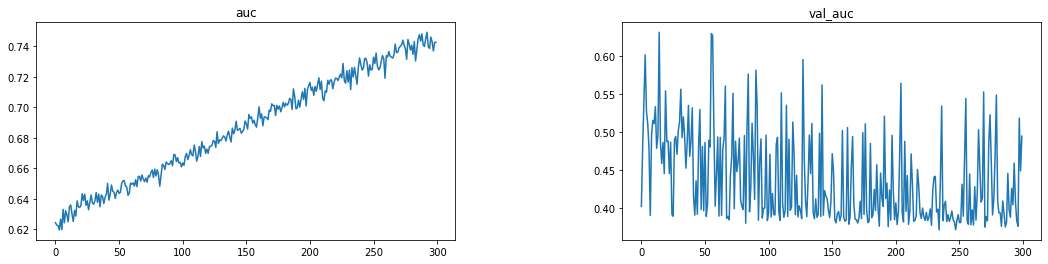

In [62]:
history_dict = history.history
history_dict.keys()

plotted_metrics = ['auc']

fig = plt.figure(figsize=(18, 4 * len(plotted_metrics)))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plotted_metrics = ['auc']

for idx, metric in enumerate(plotted_metrics):
    plt.subplot(len(plotted_metrics), 2, 2*idx+1)
    plt.title(metric)
    plt.plot(history_dict[metric])
    
    plt.subplot(len(plotted_metrics), 2, 2*idx+2)
    plt.title('val_{}'.format(metric))
    plt.plot(history_dict['val_{}'.format(metric)])

plt.show()

In [63]:
pred_down_while_steady = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 0 and x[1] == 1])
print('pred_down_while_steady: ', pred_down_while_steady)

pred_steady_while_steady = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 1 and x[1] == 1])
print('pred_steady_while_steady: ', pred_steady_while_steady)

pred_up_while_steady = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 2 and x[1] == 1])
print('pred_up_while_steady: ', pred_up_while_steady)

pred_down_while_steady:  14
pred_steady_while_steady:  349
pred_up_while_steady:  291


In [64]:
pred_down_while_down = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 0 and x[1] == 0])
print('pred_down_while_down: ', pred_down_while_down)

pred_steady_while_down = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 1 and x[1] == 0])
print('pred_steady_while_down: ', pred_steady_while_down)

pred_up_while_down = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 2 and x[1] == 0])
print('pred_up_while_down: ', pred_up_while_down)

pred_down_while_down:  43
pred_steady_while_down:  159
pred_up_while_down:  341


In [28]:
pred_down_while_up = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 0 and x[1] == 2])
print('pred_down_while_up: ', pred_down_while_up)

pred_steady_while_up = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 1 and x[1] == 2])
print('pred_steady_while_up: ', pred_steady_while_up)

pred_up_while_up = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 2 and x[1] == 2])
print('pred_up_while_up: ', pred_up_while_up)

pred_down_while_up:  29
pred_steady_while_up:  240
pred_up_while_up:  518
